# Data Analytics project - prediction of electric current prices

### Libraries

In [1]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data

#### Data 2019

In [2]:
df_ceny: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20190301_20190331.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20190301_20190331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " " + (df_ceny["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny["Data_i_Godzina"] = df_ceny["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


#### Data 2020

In [3]:
df_ceny2020: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20200301_20200331.csv", sep=";", decimal=",")
df_zapotrzebowanie2020: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20200301_20200331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data"].astype(str) + " " + (df_ceny2020["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny2020 = df_ceny2020[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data"].astype(str) + " " + (df_zapotrzebowanie2020["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie2020["Dzień tygodnia"] = df_zapotrzebowanie2020["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list2020: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2020"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2020/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list2020.append(df_naslonecznienie_temp)
df_naslonecznienie2020: pd.DataFrame = pd.concat(df_list2020)
df_naslonecznienie2020 = df_naslonecznienie2020.groupby("time").mean().reset_index()
df_naslonecznienie_marzec2020 = df_naslonecznienie2020.loc[
    df_naslonecznienie2020["time"].between(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec2020.reset_index(inplace=True)

## Demand - prior

### Polynomial regression

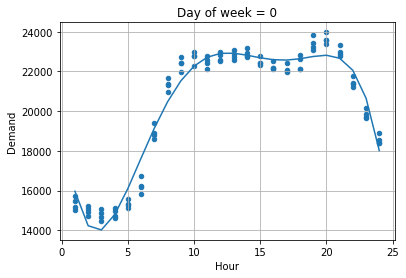

[-0.0951772727629094, 6.170089656715302, -146.56887208168098, 1496.5744008758338, -5290.536537827725, 19900.39600448531]


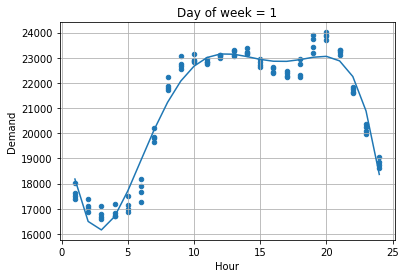

[-0.08435285184077902, 5.4350585961810705, -128.63440336440325, 1317.409553620685, -4815.654518944581, 21802.189800499018]


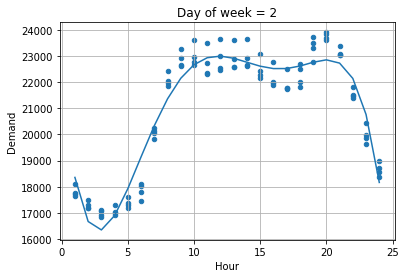

[-0.08900203660694876, 5.69693665971438, -133.43069439922624, 1347.7721299328377, -4876.525477087511, 22012.019315750233]


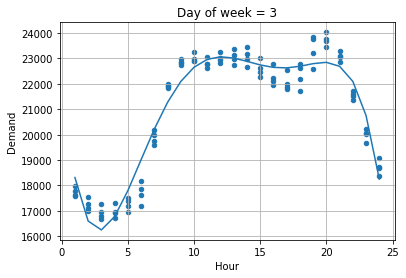

[-0.0859978858171278, 5.5394753034057, -130.8577857329545, 1335.7019564905283, -4883.989978390523, 21987.156535884907]


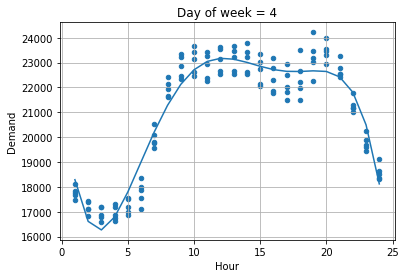

[-0.08137829642769337, 5.282360189976998, -125.97602112487601, 1297.7969178646065, -4765.511068937332, 21875.141739764484]


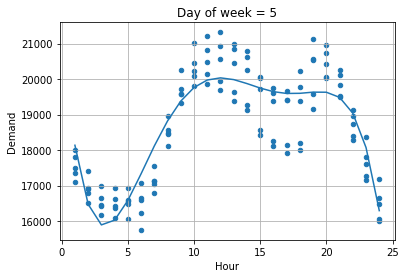

[-0.06236798573385101, 4.066955365755629, -97.87001503723778, 1031.9203546373503, -4132.198850730699, 21330.645614988207]


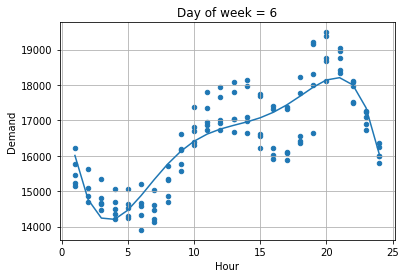

[-0.04327712656600869, 2.745583579185005, -64.70383395895932, 686.3448699755077, -2892.5153563818217, 18276.68991842087]


In [4]:
coeffs_demand: List[np.ndarray] = []
for day in range(7):
    data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc"]].loc[df_zapotrzebowanie["Dzień tygodnia"] == day]
    x = data["Godzina"]
    data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
    plt.title(f"Day of week = {day}")
    coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 5)  # Degree
    p = np.poly1d(coef)
    x = np.sort(x.drop_duplicates().to_numpy())
    plt.plot(x, p(x))
    plt.xlabel("Hour")
    plt.ylabel("Demand")
    plt.show()
    print(coef.tolist())
    coeffs_demand.append(coef)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing


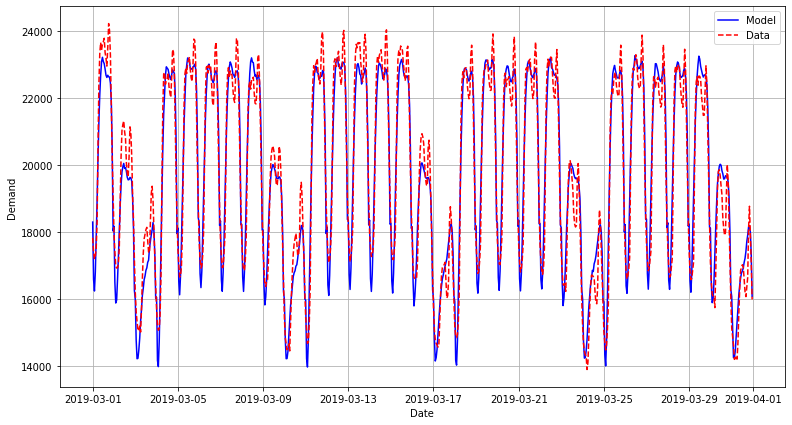

RMSE = 654.8497866343411 / (max possible) 19982.844134824838


In [5]:
model_ppc=CmdStanModel(stan_file='demand_normal_ppc.stan')
ppc = model_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    coeffs=coeffs_demand
    ))
df_ppc = ppc.draws_pd()
df_ppc_mean = df_ppc.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, np.zeros_like(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values), squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


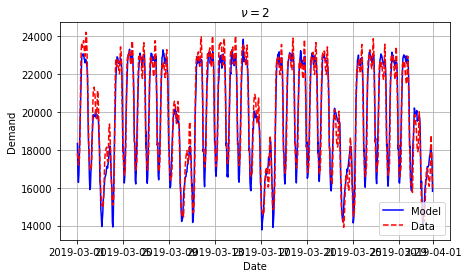

RMSE = 680.4144487489136 / (max possible) 19982.844134824838


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


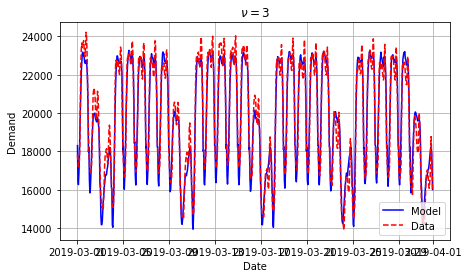

RMSE = 656.651803309936 / (max possible) 19982.844134824838


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


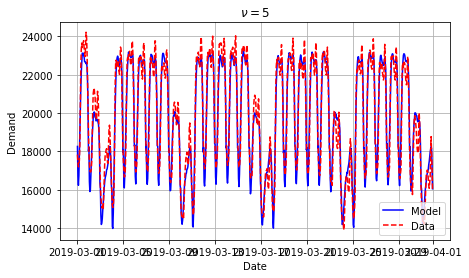

RMSE = 659.9308405624271 / (max possible) 19982.844134824838


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


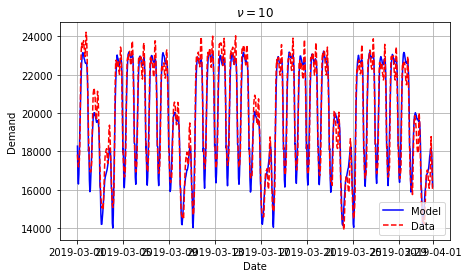

RMSE = 652.211726765491 / (max possible) 19982.844134824838


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


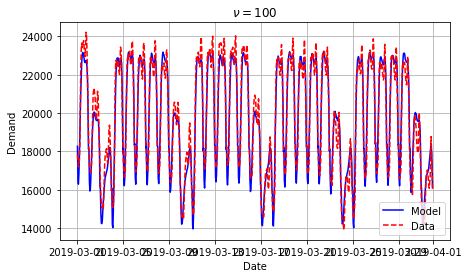

RMSE = 653.2198857366715 / (max possible) 19982.844134824838


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


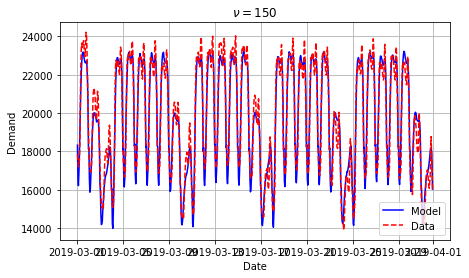

RMSE = 652.3498712871433 / (max possible) 19982.844134824838


In [6]:
model_ppc2=CmdStanModel(stan_file='demand_student_ppc.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc2 = model_ppc2.sample(show_progress=False, data=dict(
        N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, nu=nu, 
        coeffs=coeffs_demand
        ))
    df_ppc2 = ppc2.draws_pd()
    df_ppc_mean2 = df_ppc2.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
    plt.figure(figsize=(7, 4))
    plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean2, "b-",
            df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean2.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, np.zeros_like(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values), squared=False)}')
    time.sleep(1)

Through experiments, it was determined that the best results (smallest value of RMSE) are achieved with nu = 10.

### Temperature's influence on the load

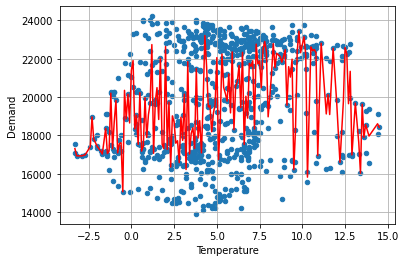

In [7]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Godzina", "Krajowe zapotrzebowanie na moc"]]
# data = data[data["Godzina"].between(11, 21)]
data.insert(len(data.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data))
    ])
data.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
plt.plot(sorted(data["Temperatura"].unique()), data.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

It seems that there is no influence of temperature on the demand, contrary to the project's assumptions.

## Generation - prior

### Determining relation with wind speed and irradiance

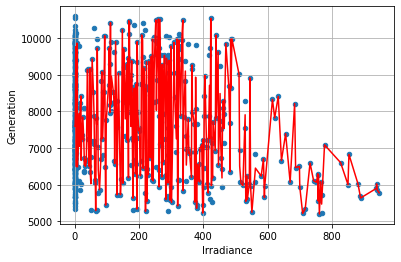

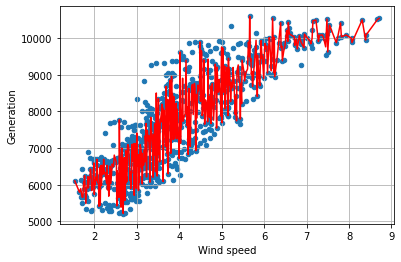

In [8]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Sumaryczna generacja nJWCD"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.plot(x="Irradiance", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Irradiance"].unique()), data.groupby(["Irradiance"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.ylabel("Generation")
plt.show()
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Wind speed"].unique()), data.groupby(["Wind speed"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.ylabel("Generation")
plt.show()

It isn't possible to sensibly fit a polynomial that will show the influence of irradiance on the generation.

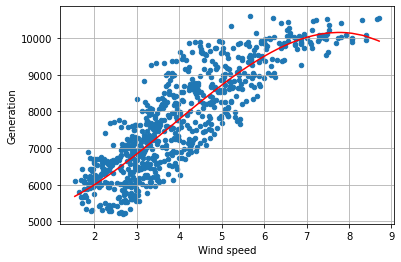

[-20.988137867227408, 242.92662547502738, 23.928925291619375, 5148.767156426628]


In [9]:
x = data["Wind speed"]
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 3)  # Degree
plt.ylabel("Generation")
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_generation.tolist())

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


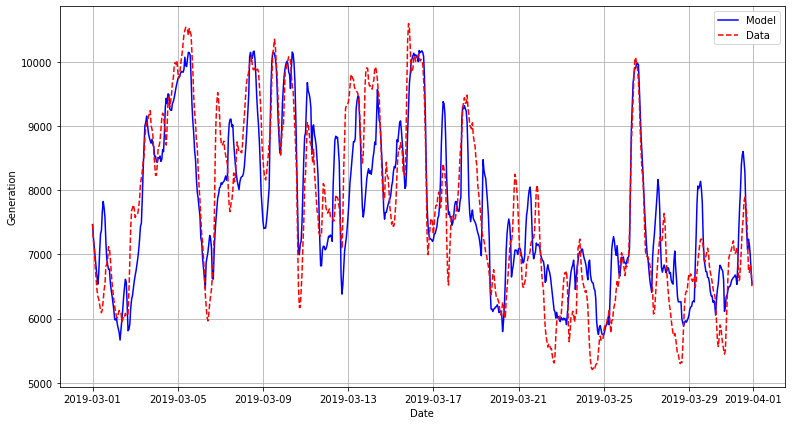

RMSE = 684.2823745678252 / (max possible) 7836.455433017564


In [10]:
model_ppc3=CmdStanModel(stan_file='generation_normal_ppc.stan')
ppc3 = model_ppc3.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef_generation
    ))
df_ppc3 = ppc3.draws_pd()
df_ppc_mean3 = df_ppc3.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(data["Data_i_Godzina"], df_ppc_mean3, "b-",
         data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
plt.xlabel("Date")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean3.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, np.zeros_like(data["Sumaryczna generacja nJWCD"].values), squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


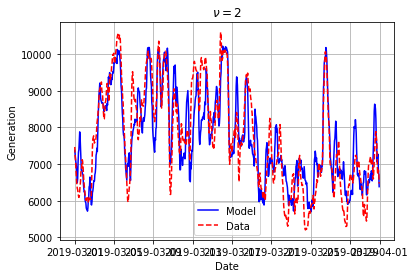

RMSE = 689.525068107535 / (max possible) 7836.455433017564


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


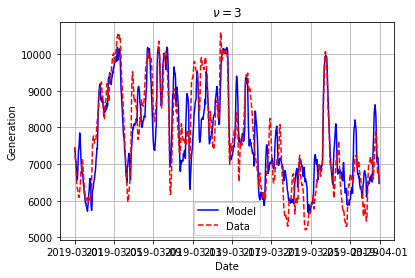

RMSE = 687.5978131770389 / (max possible) 7836.455433017564


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


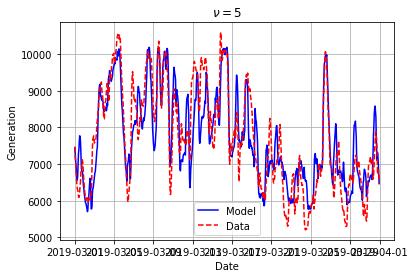

RMSE = 686.7012266533169 / (max possible) 7836.455433017564


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


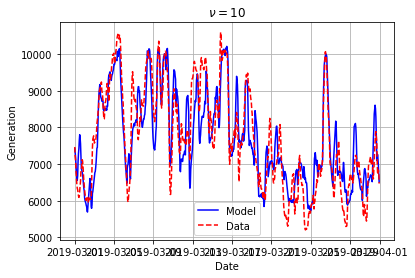

RMSE = 685.6859860580304 / (max possible) 7836.455433017564


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing


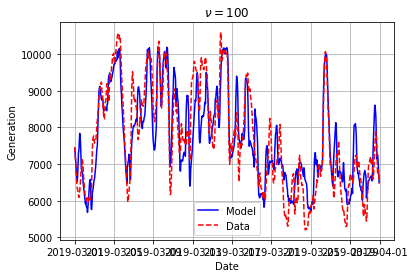

RMSE = 684.9437502465483 / (max possible) 7836.455433017564


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


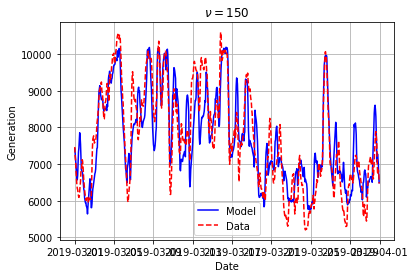

RMSE = 685.4945202067503 / (max possible) 7836.455433017564


In [11]:
model_ppc4=CmdStanModel(stan_file='generation_student_ppc.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc4 = model_ppc4.sample(show_progress=False, data=dict(
        N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef_generation, nu=nu
        ))
    df_ppc4 = ppc4.draws_pd()
    df_ppc_mean4 = df_ppc4.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
    plt.plot(data["Data_i_Godzina"], df_ppc_mean4, "b-",
            data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
    plt.xlabel("Date")
    plt.ylabel("Generation")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean4.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, np.zeros_like(data["Sumaryczna generacja nJWCD"].values), squared=False)}')
    time.sleep(1)

This time, the best amount of degrees of freedom is 100.

## Prices - prior

### Determining the relation with the residual load (Load - generation)

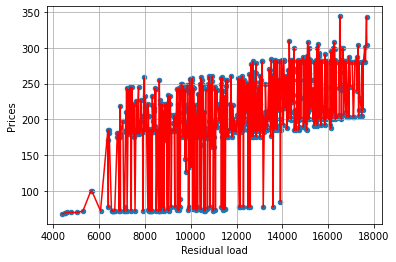

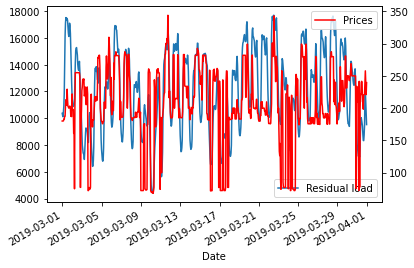

In [12]:
data = df_zapotrzebowanie.loc[:, ["Data_i_Godzina", "Sumaryczna generacja nJWCD", "Sumaryczna generacja JWCD", "Krajowe zapotrzebowanie na moc", "Dzień tygodnia"]]
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
# data = data[data["Dzień tygodnia"].between(0, 4, "both")]
# data = data[data["Prices"] > 150]
data["Residual load"] = data["Krajowe zapotrzebowanie na moc"] - data["Sumaryczna generacja nJWCD"]

data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
plt.plot(sorted(data["Residual load"].unique()), data.groupby(["Residual load"], sort=True).median()["Prices"], "r-")
plt.show()
ax = data.plot(x="Data_i_Godzina", y="Residual load")
ax.set_xlabel("Date")
ax2 = ax.twinx()
data.plot(x="Data_i_Godzina", y="Prices", ax=ax2, style="r-")
plt.show()

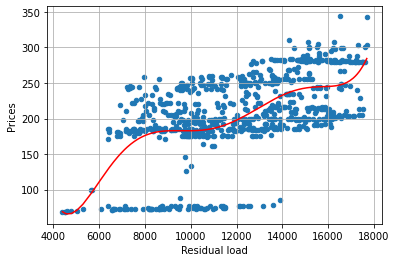

[-7.742609482176587e-26, 1.0272652464624447e-20, -4.785482025554991e-16, 1.098849285914308e-11, -1.380046392714172e-07, 0.0009561375334483479, -3.369087987094063, 4736.052313088176]


In [13]:
x = data["Residual load"]
data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
coef_prices = np.polyfit(x, data["Prices"], 7)  # Degree
p = np.poly1d(coef_prices)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_prices.tolist())

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


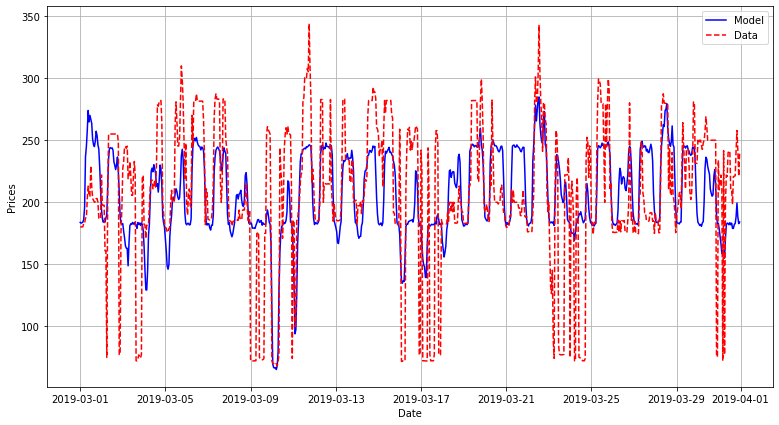

RMSE = 47.25701258698902 / (max possible) 214.47741087247994


In [14]:
model_ppc5=CmdStanModel(stan_file='prices_normal_ppc.stan')
ppc5 = model_ppc5.sample(show_progress=False, data=dict(
    N=len(data), residual=data["Residual load"].values, coeffs=coef_prices
    ))
df_ppc5 = ppc5.draws_pd()
df_ppc_mean5 = df_ppc5.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(data["Data_i_Godzina"], df_ppc_mean5, "b-",
         data["Data_i_Godzina"], data["Prices"], "r--")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(data["Prices"].values, df_ppc_mean5.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(data["Prices"].values, np.zeros_like(data["Prices"].values), squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


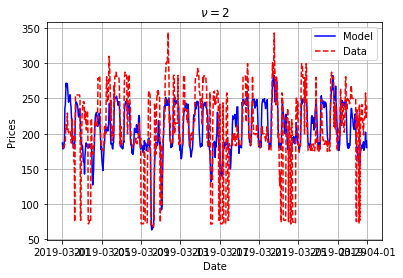

RMSE = 47.43789571036231 / (max possible) 214.47741087247994


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


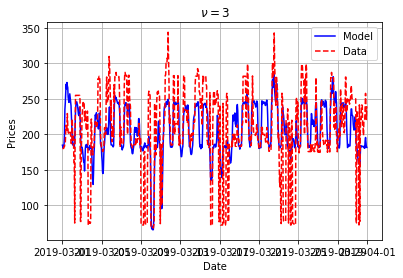

RMSE = 47.22252133249114 / (max possible) 214.47741087247994


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


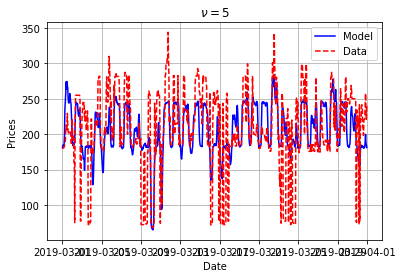

RMSE = 47.286333347113555 / (max possible) 214.47741087247994


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


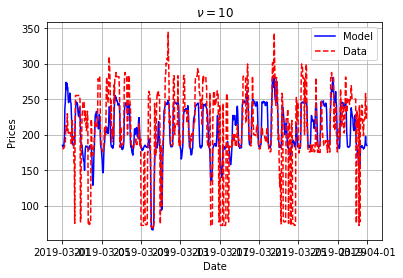

RMSE = 47.267800439680116 / (max possible) 214.47741087247994


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


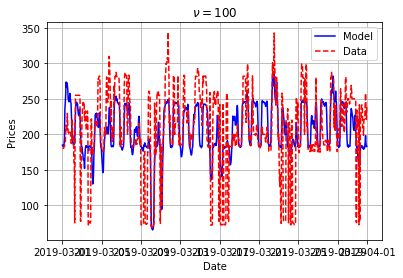

RMSE = 47.19011002009037 / (max possible) 214.47741087247994


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


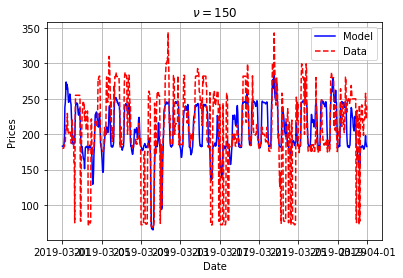

RMSE = 47.190202808840084 / (max possible) 214.47741087247994


In [15]:
model_ppc6=CmdStanModel(stan_file='prices_student_ppc.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc6 = model_ppc6.sample(show_progress=False, data=dict(
        N=len(data), residual=data["Residual load"].values, coeffs=coef_prices, nu=nu
        ))
    df_ppc6 = ppc6.draws_pd()
    df_ppc_mean6 = df_ppc6.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]
    plt.plot(data["Data_i_Godzina"], df_ppc_mean6, "b-",
            data["Data_i_Godzina"], data["Prices"], "r--")
    plt.xlabel("Date")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(data["Prices"].values, df_ppc_mean6.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(data["Prices"].values, np.zeros_like(data["Prices"].values), squared=False)}')
    time.sleep(1)

Again, the smallest value of RMSE was reached with $\nu$ = 100.

## Posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


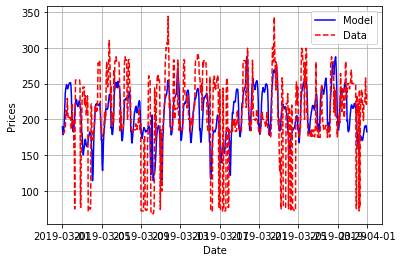

RMSE = 50.576133313694534 / (max possible) 214.47741087247994


In [16]:
data = df_zapotrzebowanie.loc[:, ["Dzień tygodnia", "Godzina", "Data_i_Godzina"]]
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[
        df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]
        ]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
y_true = data["Prices"]
model_posterior = CmdStanModel(stan_file='posterior.stan')
posterior = model_posterior.sample(show_progress=False, data=dict(
    N_historic=len(data), N_predict=len(data), prices_historic=y_true.values, day_of_week_historic=data["Dzień tygodnia"].values, 
    hour_historic=data["Godzina"].values, wind_speed_historic=data["Wind speed"].values, day_of_week_predict=data["Dzień tygodnia"].values, 
    hour_predict=data["Godzina"].values, wind_speed_predict=data["Wind speed"].values, coeffs_demand=coeffs_demand, 
    coeffs_generation=coef_generation, coeffs_prices=coef_prices
    ))
df_posterior = posterior.draws_pd()
df_posterior_mean = df_posterior.mean()[[f"posterior_prices[{i}]" for i in range(1, len(data) + 1)]]
plt.plot(data["Data_i_Godzina"], df_posterior_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.grid(True)
plt.legend(["Model", "Data"])
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_posterior_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')